In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
#df_ratios = pd.read_csv('final_data_ratios.csv')
df_ratios = pd.read_csv('2020_rmse.csv')
df_ratios.head()

,Unnamed: 0,index,company,IQ_TOTAL_ASSETS,IQ_RETURN_ASSETS,IQ_RETURN_CAPITAL,IQ_RETURN_EQUITY,IQ_RETURN_INVESTED_CAPITAL,IQ_RETURN_COMMON_EQUITY,IQ_GROSS_MARGIN,...,industry_Consumer Staples,industry_Energy,industry_Financials,industry_Health Care,industry_Industrials,industry_Information Technology,industry_Materials,industry_Real Estate,industry_Utilities,RnD_OVER_TA_CAT
0,0,0,3000,62008.000,-11.3296,-20.483800,-46.883132,-26.461100,-3.766811,-29.797500,...,0,0,0,0,1,0,0,0,0,3288.792232
1,1,1,3001,449.008,14.8508,18.960400,24.651600,18.423000,24.651600,30.288300,...,0,0,0,0,1,0,0,0,0,3288.792232
2,2,2,3002,323888.000,12.5089,21.457800,73.685500,22.441900,73.685500,38.233200,...,0,0,0,0,0,1,0,0,0,18752.000000
3,3,3,3003,6029.188,5.5472,6.484400,17.775500,7.379100,17.775500,34.010400,...,0,0,0,0,1,0,0,0,0,3288.792232
4,4,4,3004,20438.638,1.3546,-4.456946,10.240500,-19.703648,10.240500,47.020922,...,0,0,1,0,0,0,0,0,0,3288.792232


In [3]:
# Normalization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
for i in df_ratios.columns[3:]:
    df_ratios[i] = min_max_scaler.fit_transform(df_ratios[[i]].to_numpy())*1000
    df_ratios[i] = df_ratios[i].apply(lambda x: np.log10(x + 0.01))
    ### this normalization is arbitrary, but should put all nos. in comparable basis of the same magnitude - can see the
    ###   describe statistics below
df_ratios.head(10)
    #rename columns
df_rename = pd.read_excel('rename_file.xlsx')   
for i in range(len(df_rename)):
    df_ratios = df_ratios.rename(columns={df_rename['Name1'][i]: df_rename['Name2'][i]})

In [4]:
df_ratios_new=df_ratios
X = df_ratios_new.iloc[:,3:-1]
y = df_ratios_new.iloc[:,-1]

In [5]:
Train, Test = train_test_split(df_ratios_new, test_size=0.4, random_state=42)
X_train, y_train = Train.iloc[:,3:-1], Train.iloc[:,-1]
X_test, y_test = Test.iloc[:,3:-1], Test.iloc[:,-1]

In [6]:
# hyper parameter setting
params = {'num_leaves':491,
          'min_data_in_leaf':106,
          'objective':'binary',# binary classification
          'max_depth':5, # no limit
          'boosting_type':'gbdt',#'dart','goss','rf'
          'metric':'auc',
          'verbosity':-1, 
          'random_state':42
}

In [7]:
# to save feature importance
feature_importance = pd.DataFrame(index=None)

feature_importance['features'] = X_train.columns

In [8]:
len(X.columns)

70

In [9]:
# k fold cross validation
folds = KFold(n_splits=5)

splits = folds.split(X,y)

In [10]:
best_mse = 999999999
best_model = None

for k,(train_indices, val_indices) in enumerate(splits):
    print(f'{k}th fold')
    X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
    
    train_dataset = lgb.Dataset(X_train,label=y_train)
    val_dataset = lgb.Dataset(X_val,label=y_val)
    
    lgb_model = lgb.train(
        params=params,
        train_set = train_dataset,
        num_boost_round = 10000,
        valid_sets = val_dataset,
        valid_names = 'validation',
        early_stopping_rounds = 50,
    )
    feature_importance[f'fold_{k+1}'] = lgb_model.feature_importance()
    
    y_val_pred = lgb_model.predict(X_val)
    
    mse = mean_squared_error(y_val,y_val_pred)
    print(f'fold {k+1} | MSE: {mse}')
    
    if mse < best_mse:
        best_mse = mse
        best_model = lgb_model

0th fold
[1]	validation's auc: 0.853616
Training until validation scores don't improve for 50 rounds
[2]	validation's auc: 0.863515
[3]	validation's auc: 0.881544
[4]	validation's auc: 0.882464
[5]	validation's auc: 0.888276
[6]	validation's auc: 0.888922
[7]	validation's auc: 0.893704
[8]	validation's auc: 0.895041
[9]	validation's auc: 0.8966
[10]	validation's auc: 0.896326
[11]	validation's auc: 0.898868
[12]	validation's auc: 0.900431
[13]	validation's auc: 0.901597
[14]	validation's auc: 0.903758
[15]	validation's auc: 0.903779
[16]	validation's auc: 0.906208
[17]	validation's auc: 0.905643
[18]	validation's auc: 0.907199
[19]	validation's auc: 0.907625
[20]	validation's auc: 0.909765
[21]	validation's auc: 0.909901
[22]	validation's auc: 0.910716
[23]	validation's auc: 0.911688
[24]	validation's auc: 0.91079
[25]	validation's auc: 0.91125
[26]	validation's auc: 0.912091
[27]	validation's auc: 0.912229
[28]	validation's auc: 0.912417
[29]	validation's auc: 0.912608
[30]	validation

[160]	validation's auc: 0.938458
[161]	validation's auc: 0.938555
[162]	validation's auc: 0.938401
[163]	validation's auc: 0.938257
[164]	validation's auc: 0.938138
[165]	validation's auc: 0.938005
[166]	validation's auc: 0.937711
[167]	validation's auc: 0.937619
[168]	validation's auc: 0.937377
[169]	validation's auc: 0.937608
[170]	validation's auc: 0.937444
[171]	validation's auc: 0.937536
[172]	validation's auc: 0.937588
[173]	validation's auc: 0.937716
[174]	validation's auc: 0.937644
[175]	validation's auc: 0.937866
[176]	validation's auc: 0.937763
[177]	validation's auc: 0.93783
[178]	validation's auc: 0.937789
[179]	validation's auc: 0.937789
[180]	validation's auc: 0.937737
[181]	validation's auc: 0.937953
[182]	validation's auc: 0.937933
[183]	validation's auc: 0.937907
[184]	validation's auc: 0.937732
[185]	validation's auc: 0.937778
[186]	validation's auc: 0.937644
[187]	validation's auc: 0.937938
[188]	validation's auc: 0.938036
[189]	validation's auc: 0.93803
[190]	valida

[2]	validation's auc: 0.869159
[3]	validation's auc: 0.882591
[4]	validation's auc: 0.895668
[5]	validation's auc: 0.906162
[6]	validation's auc: 0.901257
[7]	validation's auc: 0.906517
[8]	validation's auc: 0.906946
[9]	validation's auc: 0.909986
[10]	validation's auc: 0.908968
[11]	validation's auc: 0.911971
[12]	validation's auc: 0.911674
[13]	validation's auc: 0.912429
[14]	validation's auc: 0.91339
[15]	validation's auc: 0.912639
[16]	validation's auc: 0.912841
[17]	validation's auc: 0.914157
[18]	validation's auc: 0.914817
[19]	validation's auc: 0.915762
[20]	validation's auc: 0.916084
[21]	validation's auc: 0.916517
[22]	validation's auc: 0.916562
[23]	validation's auc: 0.91657
[24]	validation's auc: 0.917911
[25]	validation's auc: 0.919021
[26]	validation's auc: 0.919953
[27]	validation's auc: 0.919813
[28]	validation's auc: 0.920803
[29]	validation's auc: 0.921587
[30]	validation's auc: 0.922973
[31]	validation's auc: 0.922989
[32]	validation's auc: 0.923394
[33]	validation's 

In [11]:
best_mse

0.602233749047909

In [12]:
feature_importance['average'] = feature_importance[[f'fold_{k+1}' for k in range (folds.n_splits-1)]].mean(axis=1)

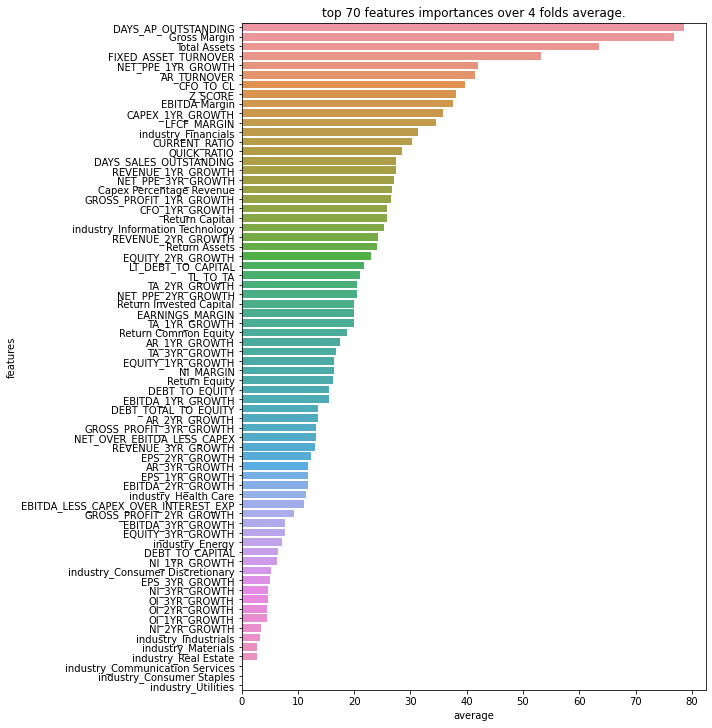

In [13]:
# visualize top 50 features
plt.figure(figsize=(10,10))
sns.barplot(data=feature_importance.sort_values(by='average',ascending=False).head(70),
           x='average',
           y='features')
plt.tight_layout()
plt.title(f'top 70 features importances over {folds.n_splits-1} folds average.')
plt.savefig('top 70 features LightGBM regression 2020.jpg', dpi=1200)